# ALE plots

In the previous week,we fit a neural network regression model on the concrete dataset. This week, we will use ALE plots to intrepret the effects and quantify the importance of each input variable on the response, as captured by the trained neural network network model. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPRegressor

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")
crt.head()

,Cement,Slag,FlyAsh,Water,SPlast,CAgg,FAgg,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
# standardize predictors
X = crt.drop('Strength',axis=1).values # extract as numpy ndarray
X_mean,X_std = X.mean(axis=0),X.std(axis=0)
X = (X-X_mean)/X_std

# standardize response
y = crt['Strength'].values
y_mean,y_std = y.mean(),y.std()
y = (y-y_mean)/y_std

# define a neural network model
nn_model = MLPRegressor(
    hidden_layer_sizes=20, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    solver='lbfgs', # deterministic optimizer (not the default)
    alpha=0.01,# regularization parameter
    max_iter = 1000 # number of LBFGS steps
)

# fit model
_ = nn_model.fit(X,y)

/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


We will be using the `alepython` library for generating ALE plots. The library is not posted to the offical PyPi repository, but is available from Github (https://github.com/blent-ai/ALEPython). If you have setup the environment from the yml file posted to canvas, this library will already be installed. If you haven't done so, open terminal (Anaconda prompt on Windows) and run

```bash
pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
```

The library currently supports only quantitative features. 

The default plot function from this library has limited customizability. We will therefore manually extract and plot the computed ALE values. The functions to do are included in the script file `ale_utils.py`.

In [5]:
from ale_utils import first_order_aleplot_quant, second_order_aleplot_quant

In [6]:
# alepython requires a dataframe
X_dat = pd.DataFrame(X,columns=crt.drop('Strength',axis=1).columns)

X_dat

,Cement,Slag,FlyAsh,Water,SPlast,CAgg,FAgg,Age
0,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,0.863154,-1.217670,-0.279733
1,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,1.056164,-1.217670,-0.279733
2,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,3.553066
3,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677
4,-0.790459,0.678408,-0.847144,0.488793,-1.039143,0.070527,0.647884,4.978487
...,...,...,...,...,...,...,...,...
1025,-0.045645,0.488235,0.564545,-0.092171,0.451410,-1.323005,-0.065893,-0.279733
1026,0.392819,-0.856888,0.960068,0.676200,0.702626,-1.994680,0.496893,-0.279733
1027,-1.270088,0.759579,0.850635,0.521589,-0.017528,-1.036064,0.080107,-0.279733
1028,-1.168610,1.308065,-0.847144,-0.279579,0.853356,0.214641,0.191166,-0.279733


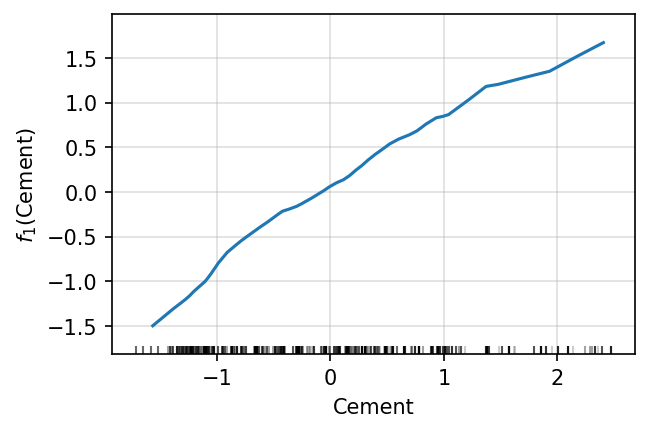

In [7]:
fig,ax = plt.subplots(1,1,figsize=(4.5,3))

# plot the first order ALE effects for feature 'Cement'
ax,ale_cement,_ = first_order_aleplot_quant(
    predictor=nn_model.predict, # prediction function
    train_data=X_dat,
    feature='Cement',
    bins=50,ax=ax
)

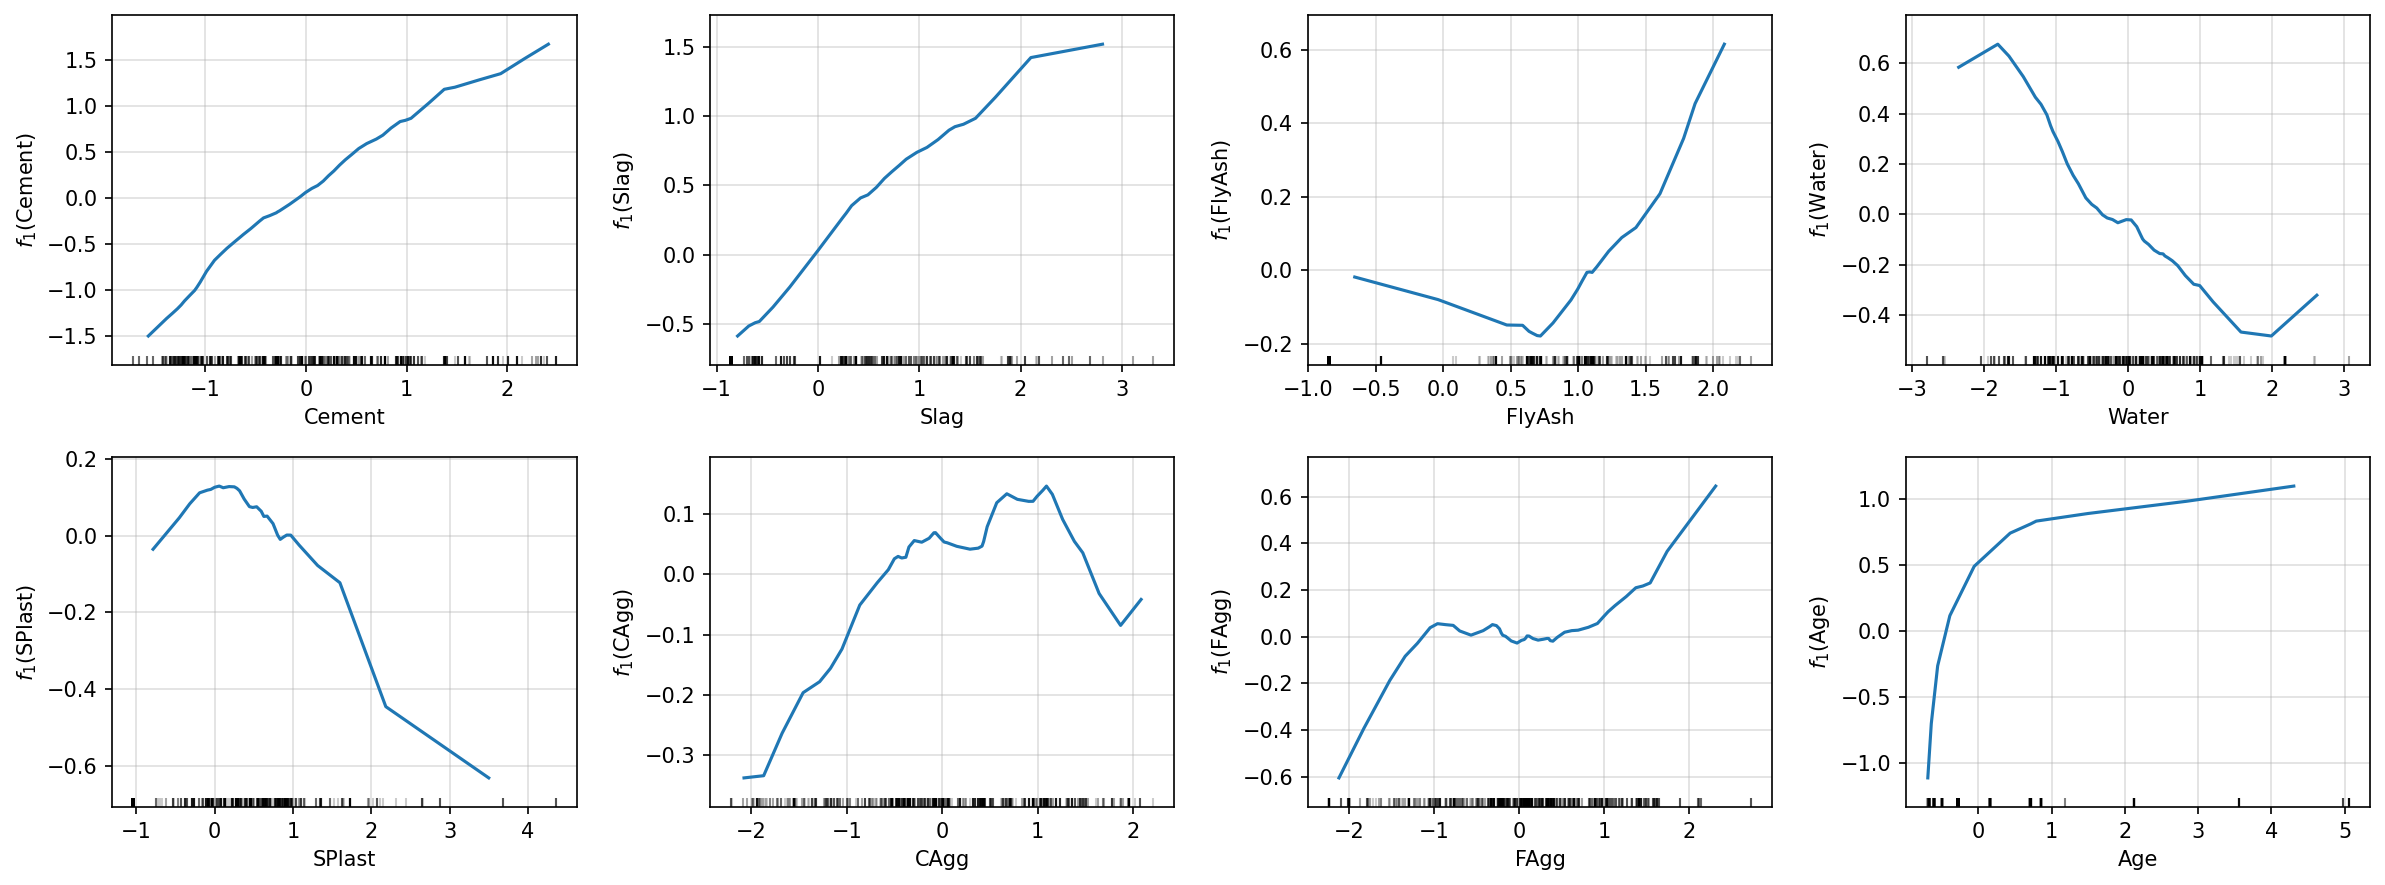

In [8]:
# first order effects of all 8 predictors, plotting in a 2 x 4 grid
num_rows=2
num_cols=4

fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature = X_dat.columns[num_cols*i + j]
        _ = first_order_aleplot_quant(nn_model.predict,X_dat,feature,bins=50,ax=axs[i,j])

fig.tight_layout()

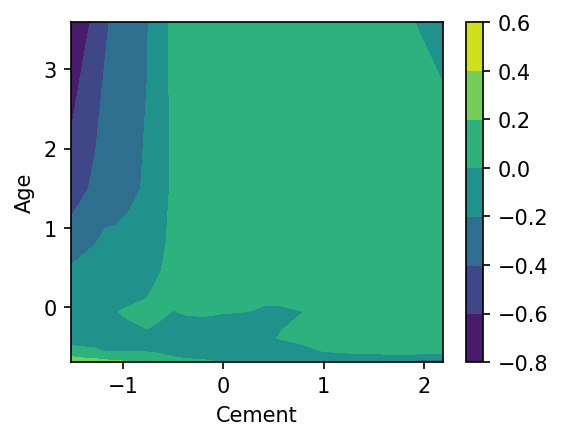

In [9]:
# Second order ALE plots
fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = second_order_aleplot_quant(
    predictor=nn_model.predict,
    train_data=X_dat,
    features=['Cement','Age'],
    fig=fig,
    ax=ax,
    bins=20,
    mark_empty=False
)

ALE values are estimated over discrete intervals/bins. In a 2-D interaction plot, there may not be data in a few bins. The ALE values are usuallly interpolated from the nearby bins. Pass `mark_empty=True` if you want to see the regions with no data.

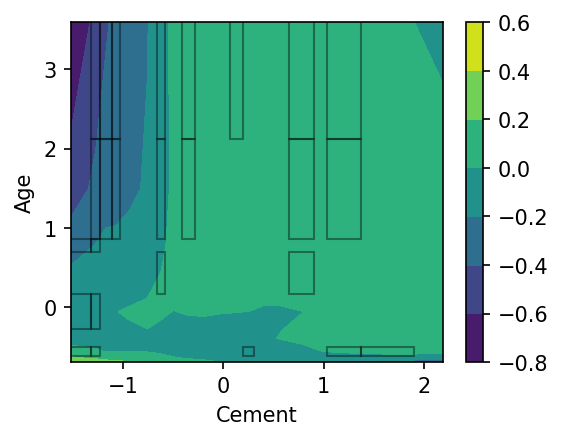

In [10]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = second_order_aleplot_quant(
    predictor=nn_model.predict,
    train_data=X_dat,
    features=['Cement','Age'],
    fig=fig,
    ax=ax,
    bins=20,
    mark_empty=True
)

So far, we have been looking at the second order interaction effects in isolation. Pass `combined=True` if you want to include the first order effects as well.

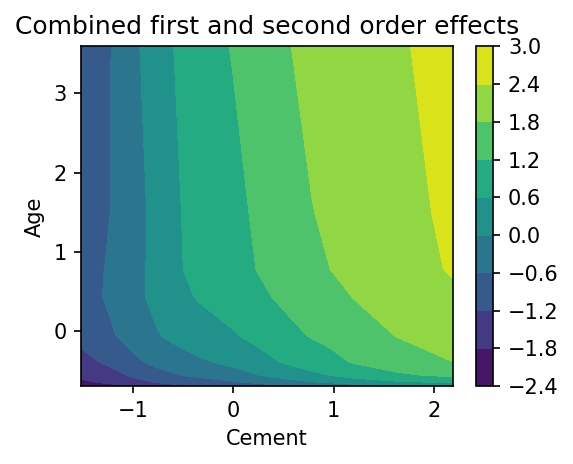

In [11]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = second_order_aleplot_quant(
    predictor=nn_model.predict,
    train_data=X_dat,
    features=['Cement','Age'],
    fig=fig,
    ax=ax,
    bins=20,
    mark_empty=False,
    combined=True
)
_ = ax.set_title('Combined first and second order effects')